# Chapter 5 - Type B (prefix_constant_rho)

Grafici Type B aggregati per target `F0*`.

Output separato:
- figura lineare
- figura log-log

per ciascun set di algoritmi:
- all
- no_pc
- hll_hllpp


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

REPO = Path('/Users/daniele/CLionProjects/satp-cpp')
RESULTS_ROOT = REPO / 'results' / 'prefix_constant_rho' / 'streaming'
OUT_DIR = REPO / 'thesis' / 'figures' / 'results'
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_N = 10_000_000
TARGET_SEED = 21041998
TARGET_F0_STAR = [1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000]

ALGO_ORDER = ['HyperLogLog++', 'HyperLogLog', 'LogLog', 'Probabilistic Counting']
COLORS = {
    'HyperLogLog++': '#1f77b4',
    'HyperLogLog': '#2ca02c',
    'LogLog': '#ff7f0e',
    'Probabilistic Counting': '#d62728',
}


In [2]:
paths = sorted(RESULTS_ROOT.glob('*/*/results_streaming.csv'))
if not paths:
    raise FileNotFoundError(f'Nessun CSV trovato in: {RESULTS_ROOT}')

frames = []
for p in paths:
    df = pd.read_csv(p)
    df['source_path'] = str(p)
    frames.append(df)

df = pd.concat(frames, ignore_index=True)
sel = df[(df['mode'] == 'streaming') &
         (df['sample_size'] == TARGET_N) &
         (df['seed'] == TARGET_SEED)].copy()

if sel.empty:
    raise ValueError('Filtro troppo restrittivo: nessun dato trovato')

sel['rho_final'] = sel['sample_size'] / sel['f0']
sel['algorithm_label'] = sel['algorithm']

print('rows:', len(sel))
print('algorithms:', sorted(sel['algorithm_label'].unique().tolist()))
print('rho_final:', sorted(sel['rho_final'].unique().tolist()))
print('f0_final:', sorted(sel['f0'].unique().tolist()))


rows: 5600
algorithms: ['HyperLogLog', 'HyperLogLog++', 'LogLog', 'Probabilistic Counting']
rho_final: [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
f0_final: [100000, 200000, 500000, 1000000, 2000000, 5000000, 10000000]


In [3]:
def interpolate_point(group: pd.DataFrame, f0_star: float):
    compact = (group.groupby('f0_mean_t', as_index=False)
                    .agg({
                        'number_of_elements_processed': 'mean',
                        'f0_heat_mean_t': 'mean',
                        'stddev': 'mean'
                    })
                    .sort_values('f0_mean_t'))

    x = compact['f0_mean_t'].to_numpy(dtype=float)
    if len(x) < 2:
        return None
    if f0_star < x.min() or f0_star > x.max():
        return None

    t_vals = compact['number_of_elements_processed'].to_numpy(dtype=float)
    y_vals = compact['f0_heat_mean_t'].to_numpy(dtype=float)
    s_vals = compact['stddev'].to_numpy(dtype=float)

    t_interp = float(np.interp(f0_star, x, t_vals))
    y_interp = float(np.interp(f0_star, x, y_vals))
    s_interp = float(np.interp(f0_star, x, s_vals))

    rho_t = t_interp / float(f0_star)
    return rho_t, y_interp, s_interp


def build_type_b_points(f0_star: int) -> pd.DataFrame:
    rows = []
    for (algo, rho_final), g in sel.groupby(['algorithm_label', 'rho_final']):
        pt = interpolate_point(g, float(f0_star))
        if pt is None:
            continue
        rho_t, y, s = pt
        rows.append({
            'algorithm_label': algo,
            'rho_final': float(rho_final),
            'rho_t': float(rho_t),
            'f0_star': float(f0_star),
            'f0_hat': float(y),
            'stddev': float(s),
        })

    out = pd.DataFrame(rows)
    if out.empty:
        return out
    return out.sort_values(['algorithm_label', 'rho_t'])


In [4]:
def plot_aggregated_type_b(tag: str, algorithms: list[str], title: str, loglog: bool):
    nrows, ncols = 3, 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(15.8, 13.0), constrained_layout=True)
    axes = np.array(axes).reshape(-1)

    def log_band_from_mean_std(mean: np.ndarray, std: np.ndarray, eps: float = 1e-12):
        m = np.maximum(mean, eps)
        cv = np.divide(std, m, out=np.zeros_like(m), where=m > 0)
        sigma_log = np.sqrt(np.log1p(cv * cv))
        low = m * np.exp(-sigma_log)
        high = m * np.exp(sigma_log)
        return low, high

    for c, f0_star in enumerate(TARGET_F0_STAR):
        ax = axes[c]
        data = build_type_b_points(f0_star)
        data = data[data['algorithm_label'].isin(algorithms)].copy()

        for algo in [a for a in ALGO_ORDER if a in algorithms]:
            sub = data[data['algorithm_label'] == algo].sort_values('rho_t')
            if sub.empty:
                continue

            x = sub['rho_t'].to_numpy(dtype=float)
            y = sub['f0_hat'].to_numpy(dtype=float)
            s = sub['stddev'].to_numpy(dtype=float)
            color = COLORS.get(algo)

            ax.plot(x, y, marker='o', linewidth=2.0, markersize=4.5, color=color, label=algo)
            if loglog:
                low, high = log_band_from_mean_std(y, s)
                ax.fill_between(x, low, high, alpha=0.16, color=color)
            else:
                ax.fill_between(x, y - s, y + s, alpha=0.16, color=color)

        truth = float(f0_star)
        ax.axhline(truth, color='black', linestyle='--', linewidth=1.4, label='F0 reale')

        ax.set_title(f'F0* = {f0_star:,}'.replace(',', '.'))
        ax.set_xlabel('ρ_t = t / F0(t)')
        ax.set_ylabel('F0_hat')

        if loglog:
            ax.set_xscale('log')
            ax.set_yscale('log')

        ax.legend(loc='best', fontsize=7)

    # Hide unused panels (7 targets in a 3x3 grid)
    for i in range(len(TARGET_F0_STAR), nrows * ncols):
        axes[i].axis('off')

    suffix = 'loglog' if loglog else 'linear'
    fig.suptitle(title + (' (log-log)' if loglog else ' (lineare)'), fontsize=13)
    out = OUT_DIR / f'typeB_prefix_constant_rho_{tag}_{suffix}.png'
    fig.savefig(out, dpi=180, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print('saved:', out)



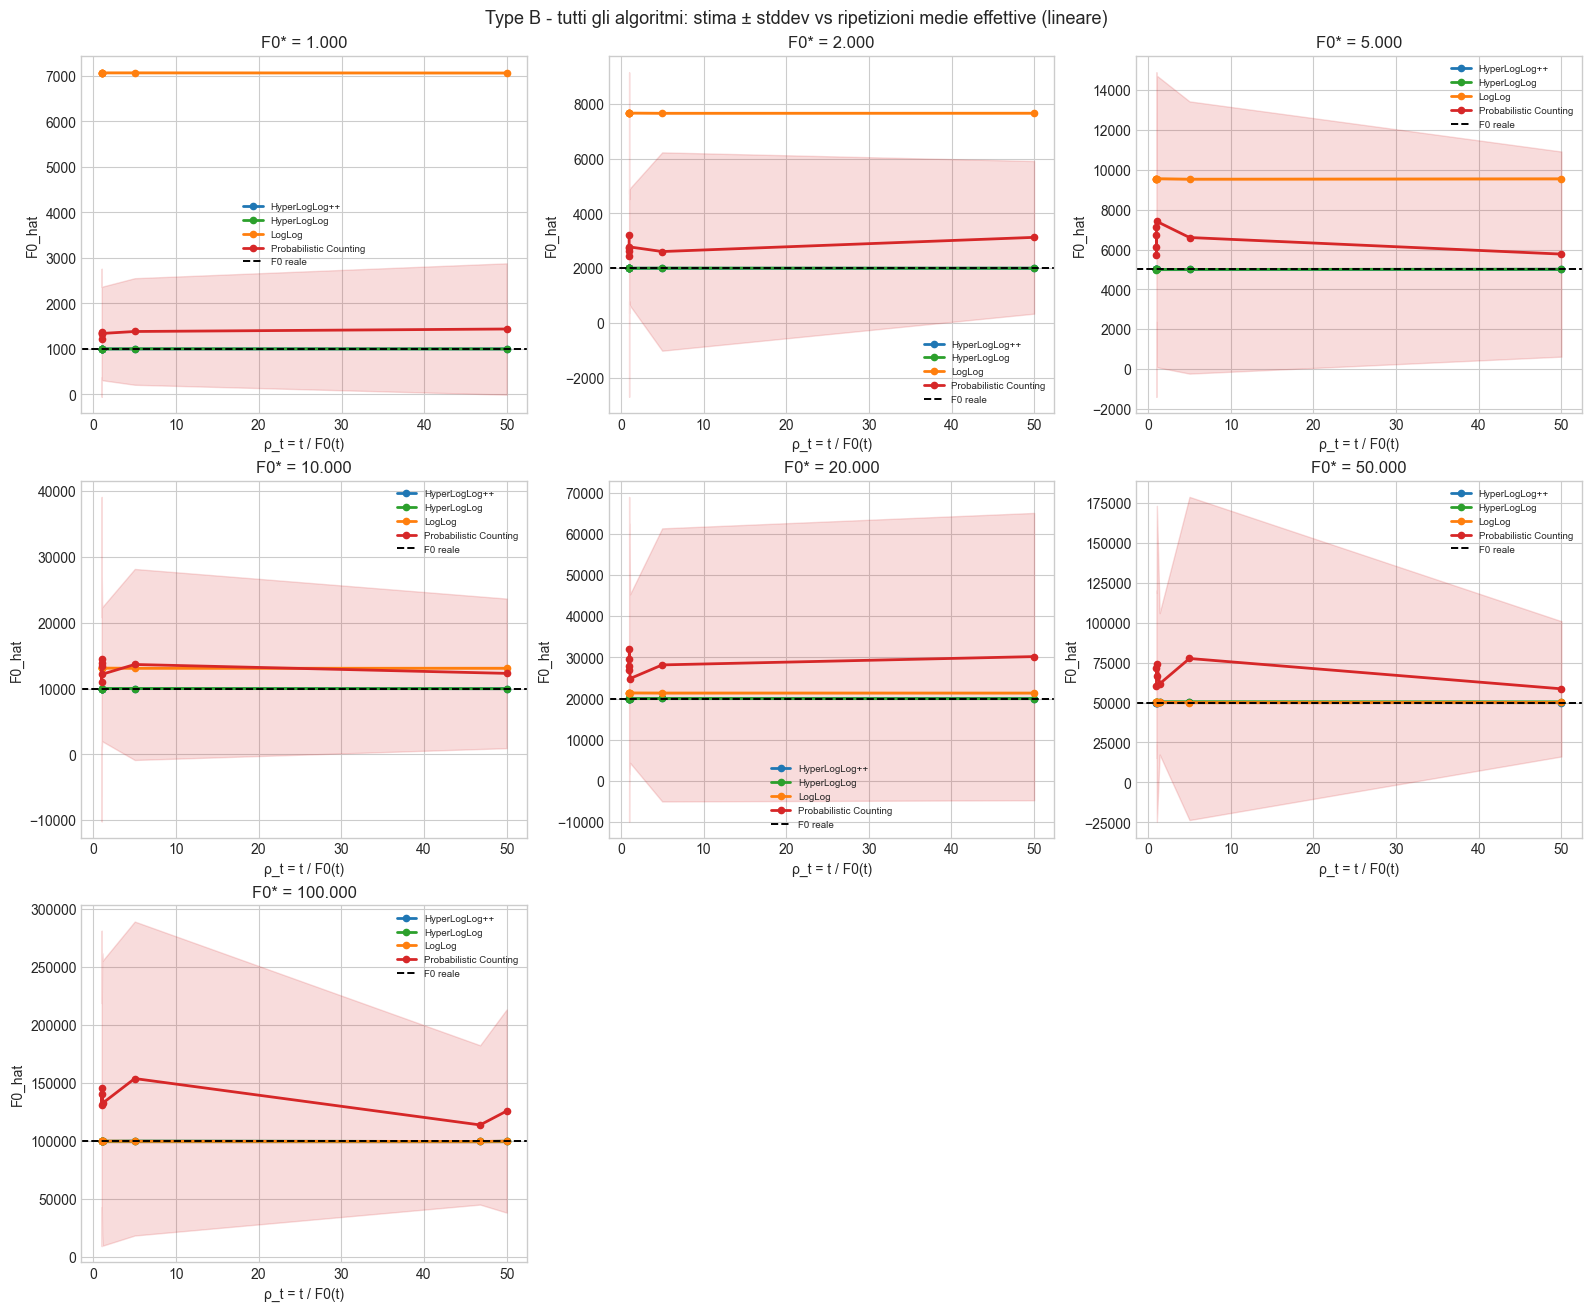

saved: /Users/daniele/CLionProjects/satp-cpp/thesis/figures/results/typeB_prefix_constant_rho_all_linear.png


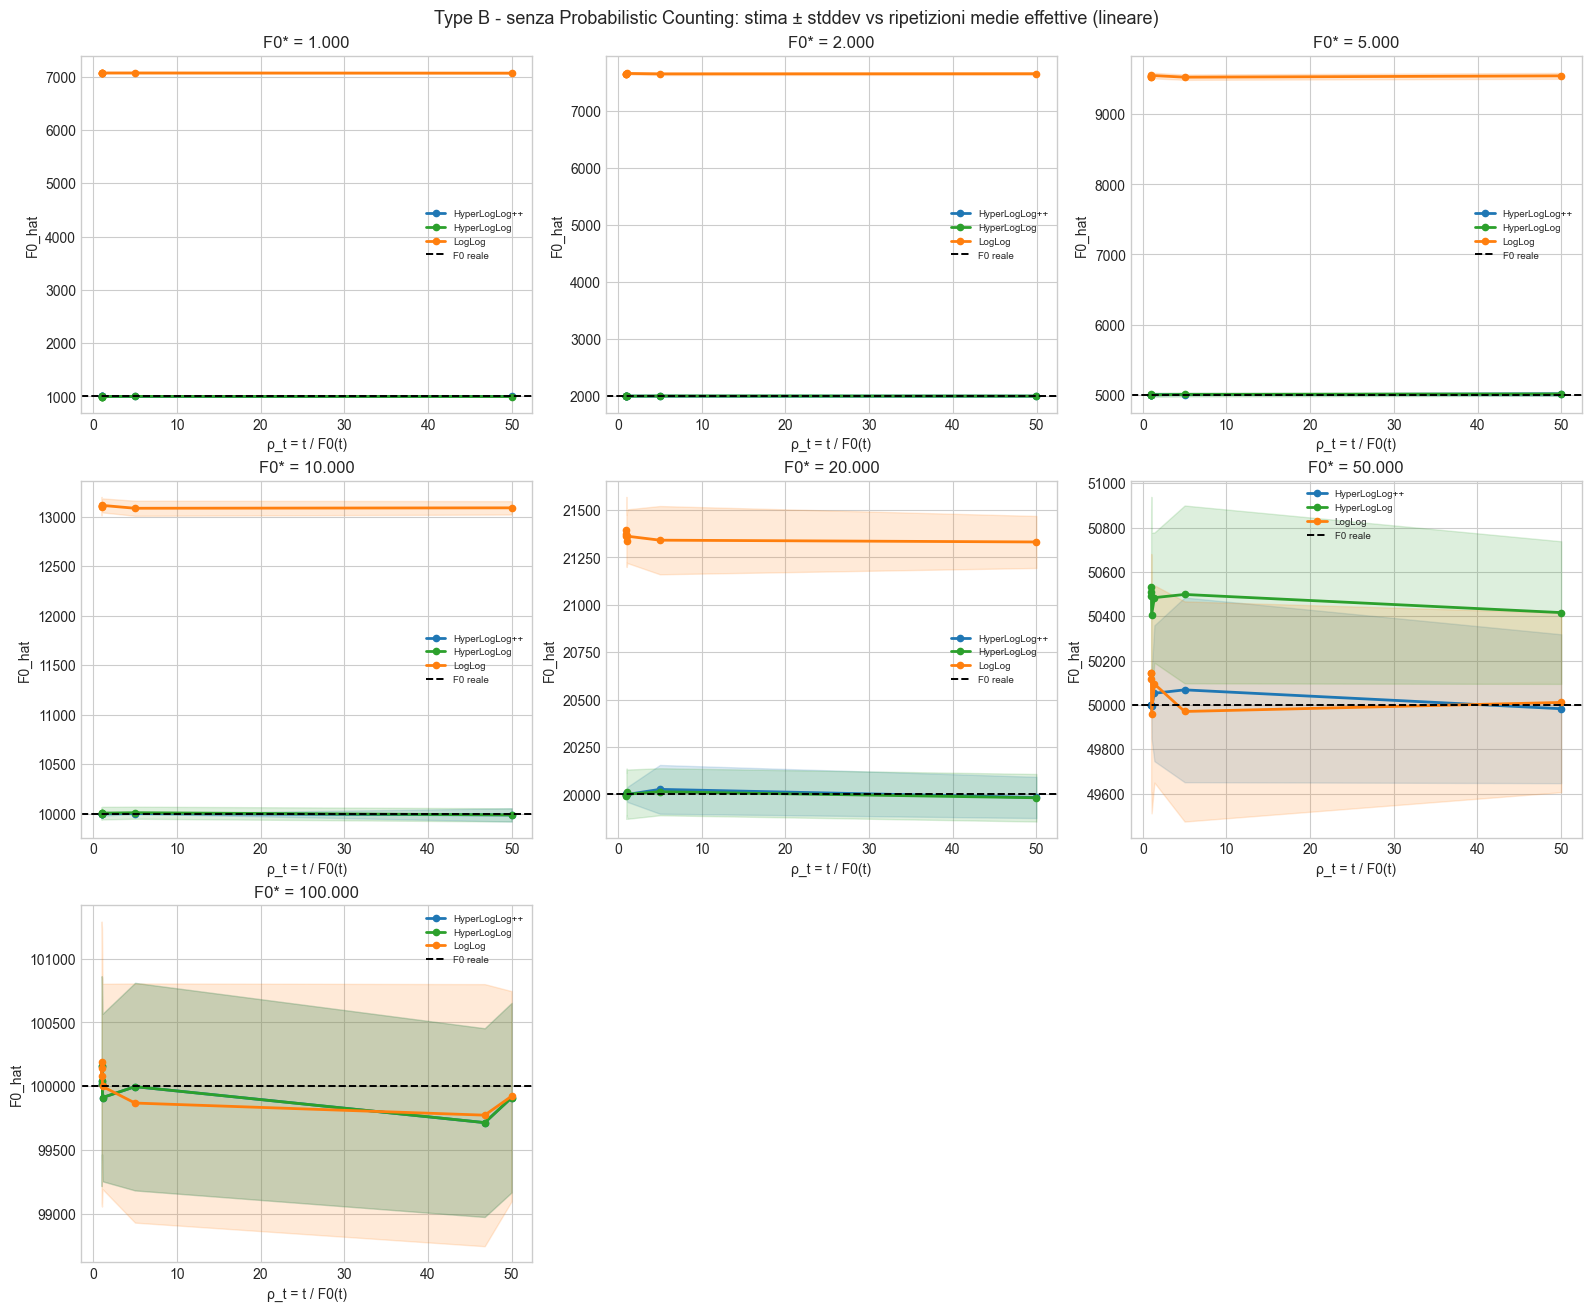

saved: /Users/daniele/CLionProjects/satp-cpp/thesis/figures/results/typeB_prefix_constant_rho_no_pc_linear.png


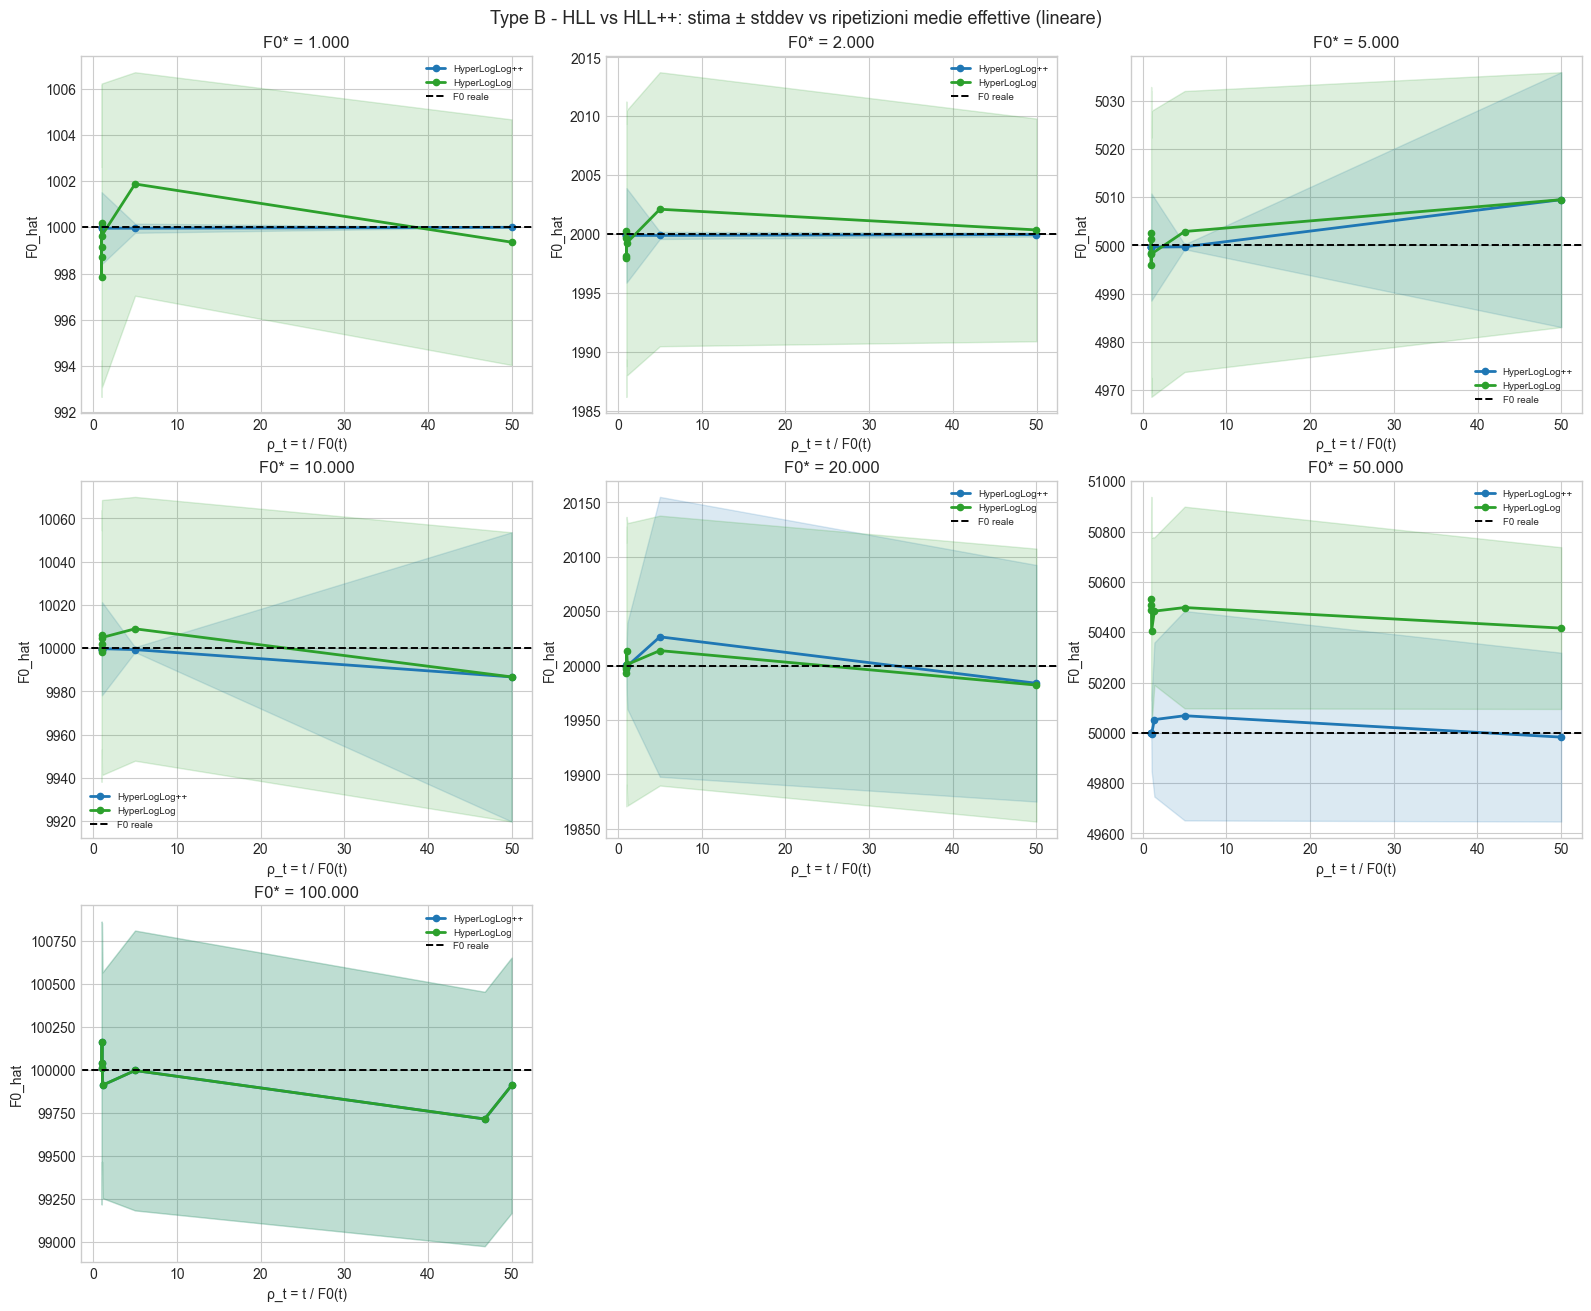

saved: /Users/daniele/CLionProjects/satp-cpp/thesis/figures/results/typeB_prefix_constant_rho_hll_hllpp_linear.png


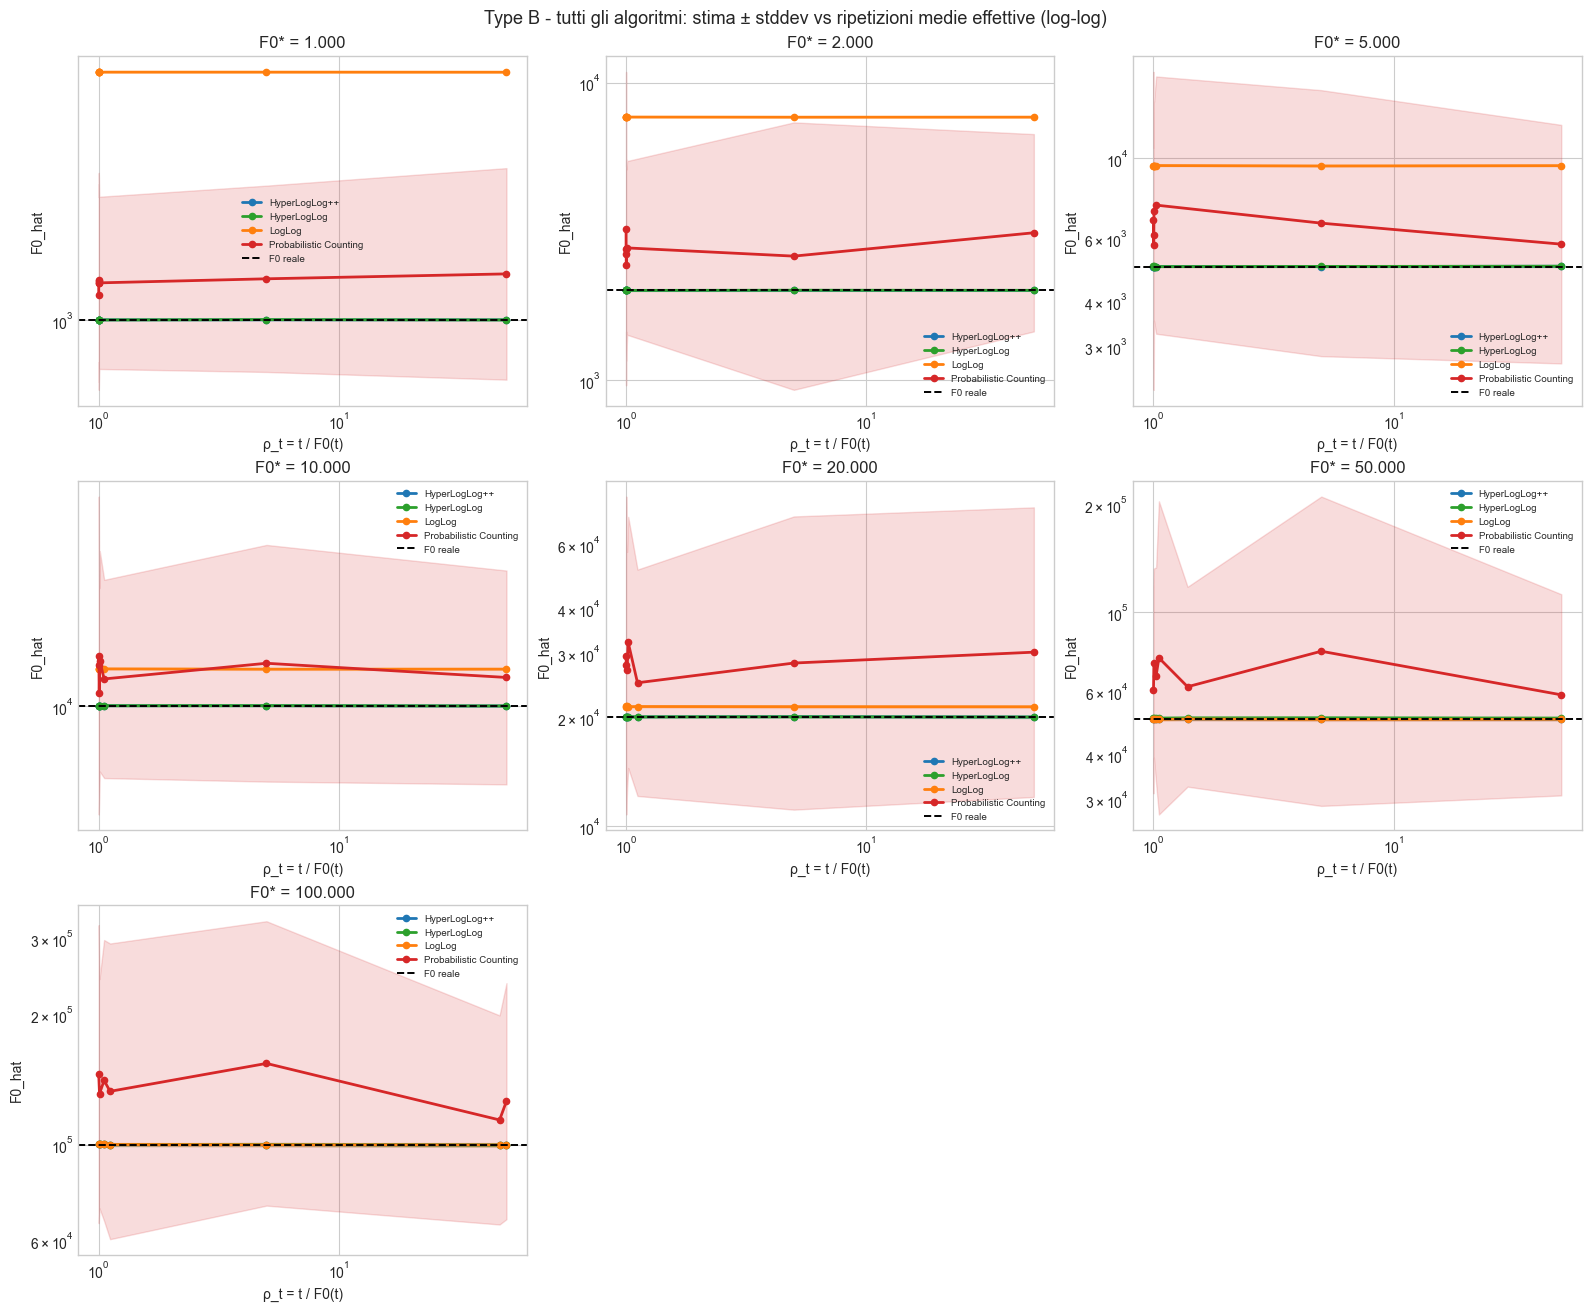

saved: /Users/daniele/CLionProjects/satp-cpp/thesis/figures/results/typeB_prefix_constant_rho_all_loglog.png


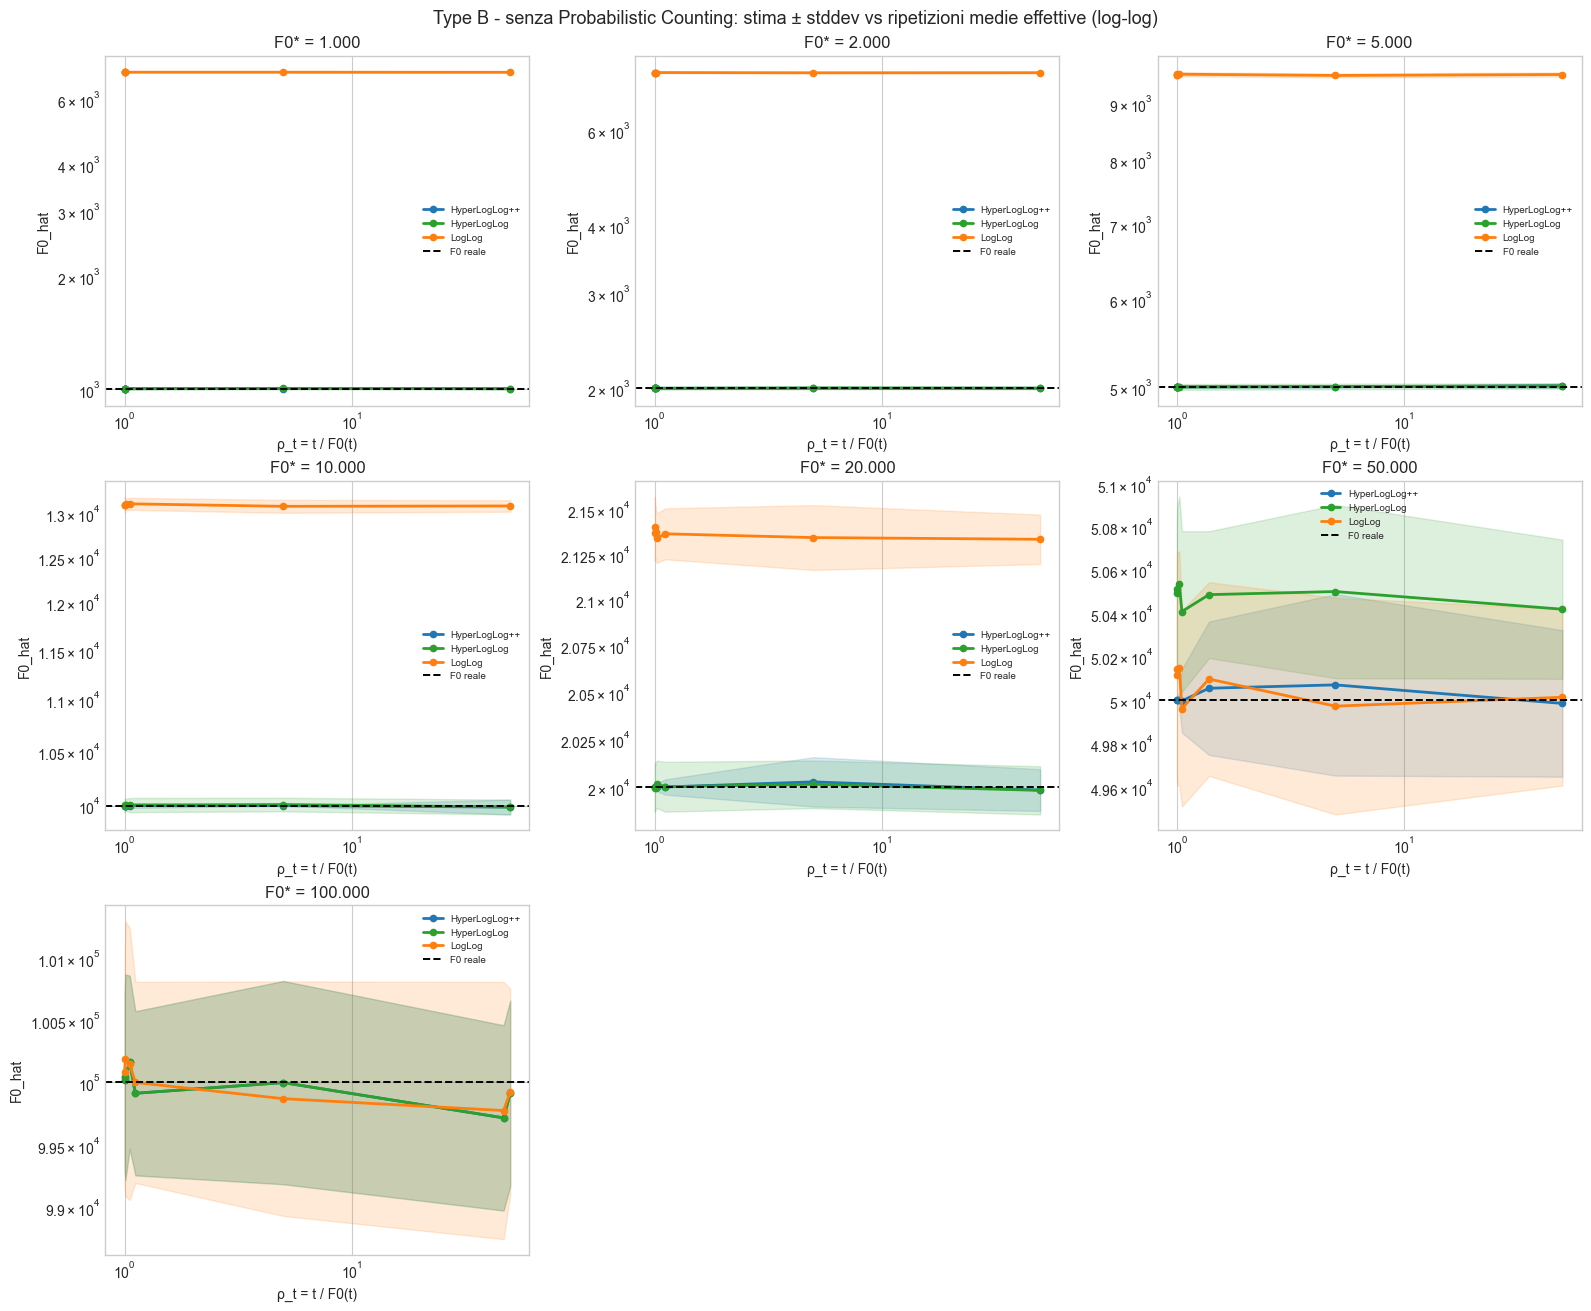

saved: /Users/daniele/CLionProjects/satp-cpp/thesis/figures/results/typeB_prefix_constant_rho_no_pc_loglog.png


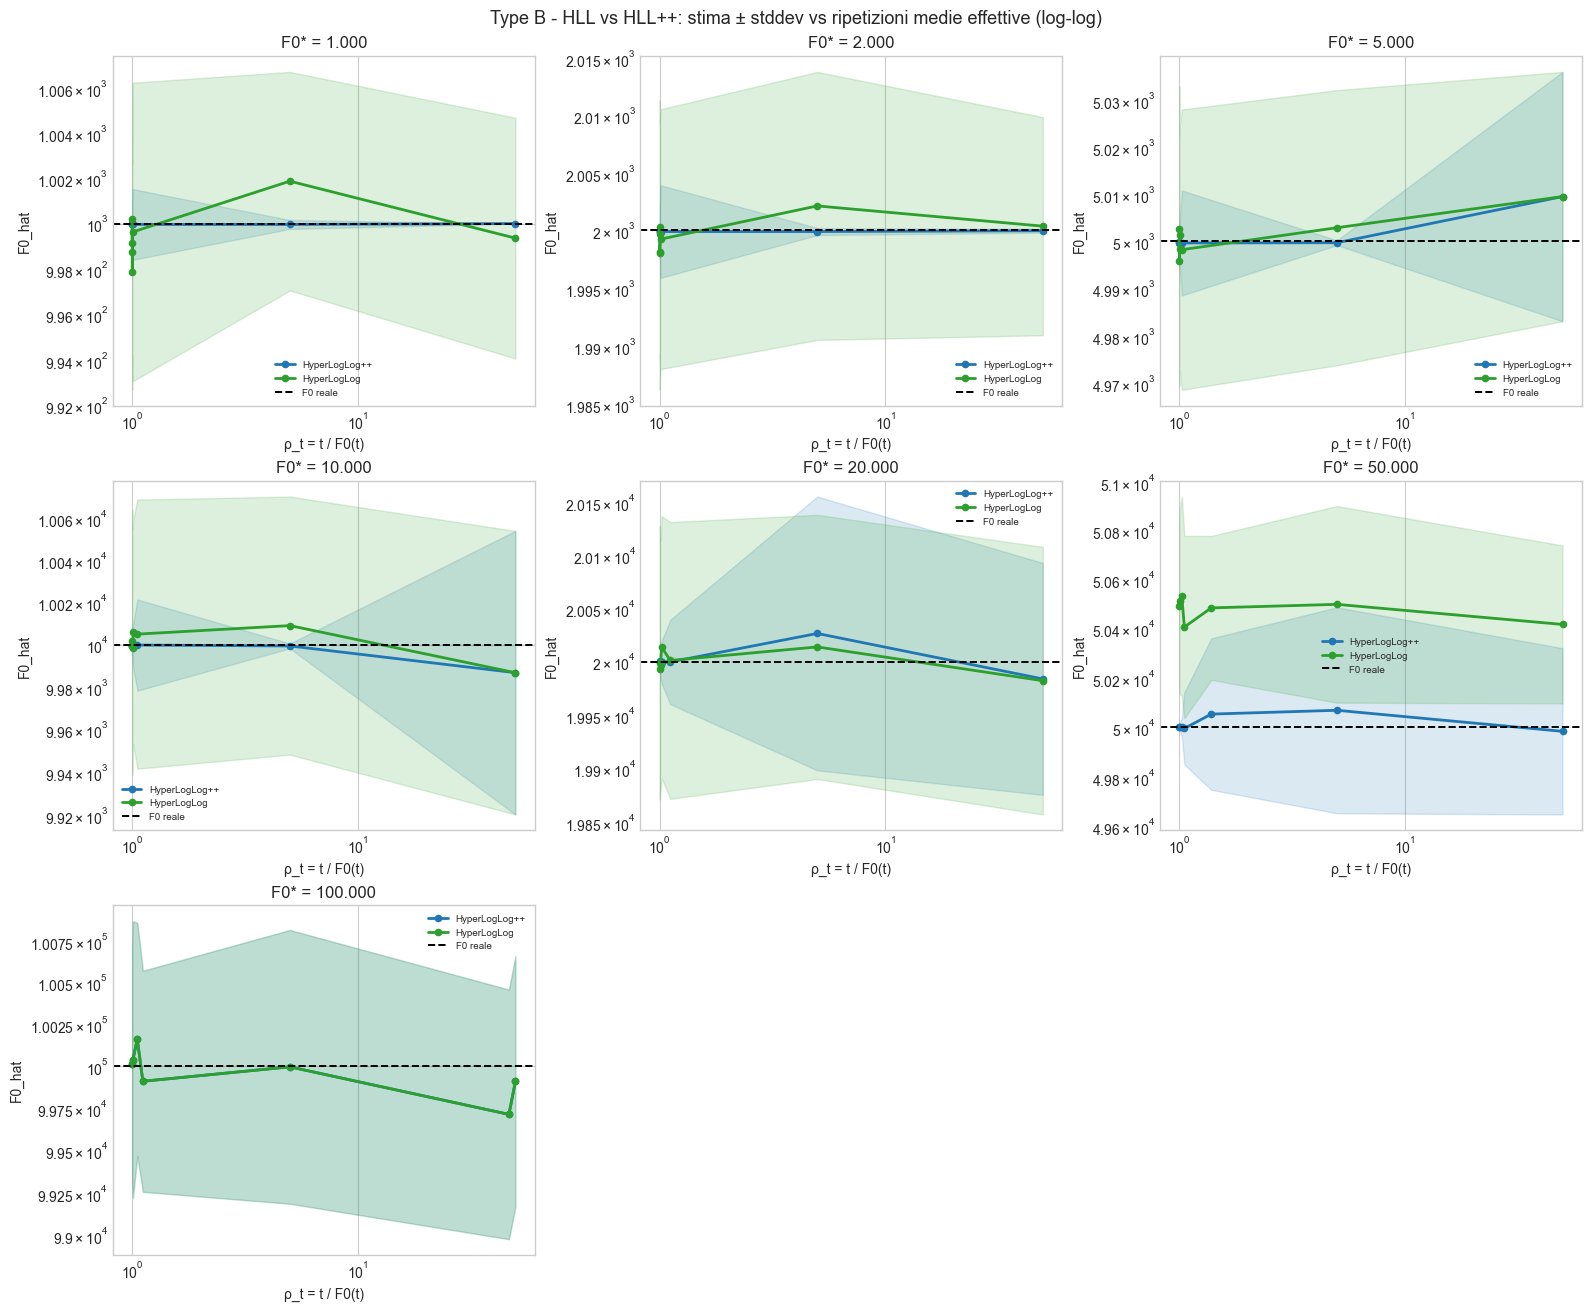

saved: /Users/daniele/CLionProjects/satp-cpp/thesis/figures/results/typeB_prefix_constant_rho_hll_hllpp_loglog.png


In [5]:
for loglog in (False, True):
    plot_aggregated_type_b(
        tag='all',
        algorithms=['HyperLogLog++', 'HyperLogLog', 'LogLog', 'Probabilistic Counting'],
        title='Type B - tutti gli algoritmi: stima ± stddev vs ripetizioni medie effettive',
        loglog=loglog,
    )

    plot_aggregated_type_b(
        tag='no_pc',
        algorithms=['HyperLogLog++', 'HyperLogLog', 'LogLog'],
        title='Type B - senza Probabilistic Counting: stima ± stddev vs ripetizioni medie effettive',
        loglog=loglog,
    )

    plot_aggregated_type_b(
        tag='hll_hllpp',
        algorithms=['HyperLogLog++', 'HyperLogLog'],
        title='Type B - HLL vs HLL++: stima ± stddev vs ripetizioni medie effettive',
        loglog=loglog,
    )
